In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---
# **Libraries Imported**
---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
tf.random.set_seed(12)

In [ ]:
!ls /

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [ ]:
!mkdir /tmp/Xray_train_data

### **Copying Dataset to target location**

In [ ]:
!cp -R "/content/drive/MyDrive/COVID-19_Radiography_Dataset/1-COVID" "/tmp/Xray_train_data"

In [ ]:
!cp -R "/content/drive/MyDrive/COVID-19_Radiography_Dataset/0-NORMAL" "/tmp/Xray_train_data"

In [ ]:
!ls "/tmp/Xray_train_data"

0-NORMAL  1-COVID


In [ ]:
!ls -1 "/tmp/Xray_train_data/1-COVID"| wc -l 

3616


In [ ]:
!ls -1 "/tmp/Xray_train_data/0-NORMAL"| wc -l 

10192


In [ ]:
train_data_dir= "/tmp/Xray_train_data"

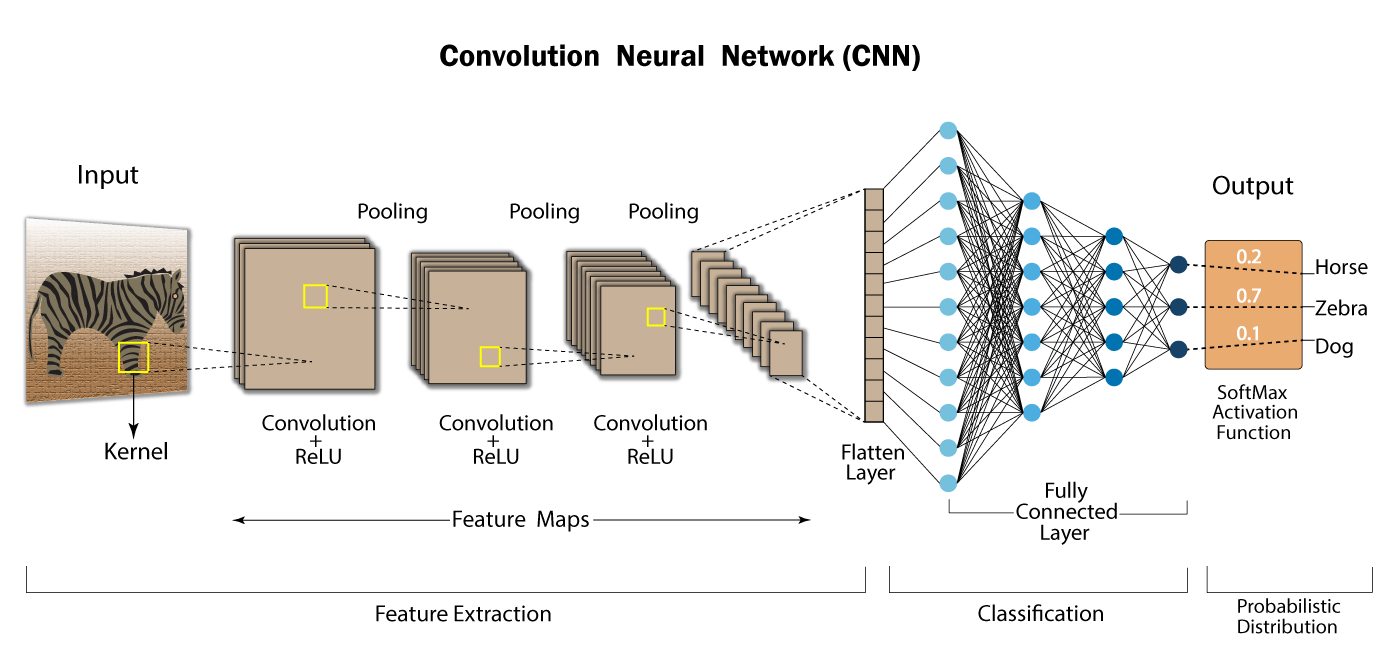




In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(.1, input_shape=(32,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width=64,64
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 9667 images belonging to 2 classes.
Found 4141 images belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13808 files belonging to 2 classes.
Using 2761 files for validation.


In [ ]:
class_weights = {0: 1.0, 1: 10192/3616} 

print('\nclass weights: ', class_weights)


class weights:  {0: 1.0, 1: 2.8185840707964602}


# **Training the model**

In [ ]:
trainer=model.fit(train_generator,
                  validation_data=validation_generator,
                  class_weight = class_weights,
                  epochs=20,
                  verbose=2)

Epoch 1/20
168/168 - 40s - loss: 6.2237 - accuracy: 0.8425 - val_loss: 1.3955 - val_accuracy: 0.9417
Epoch 2/20
168/168 - 7s - loss: 1.3629 - accuracy: 0.8946 - val_loss: 0.7067 - val_accuracy: 0.9373
Epoch 3/20
168/168 - 7s - loss: 0.8302 - accuracy: 0.9021 - val_loss: 0.4771 - val_accuracy: 0.9399
Epoch 4/20
168/168 - 7s - loss: 0.6500 - accuracy: 0.9103 - val_loss: 0.4550 - val_accuracy: 0.9408
Epoch 5/20
168/168 - 7s - loss: 0.4986 - accuracy: 0.9214 - val_loss: 0.4066 - val_accuracy: 0.9460
Epoch 6/20
168/168 - 7s - loss: 0.4279 - accuracy: 0.9200 - val_loss: 0.3040 - val_accuracy: 0.9443
Epoch 7/20
168/168 - 7s - loss: 0.3357 - accuracy: 0.9285 - val_loss: 0.2511 - val_accuracy: 0.9487
Epoch 8/20
168/168 - 7s - loss: 0.3332 - accuracy: 0.9293 - val_loss: 0.2364 - val_accuracy: 0.9478
Epoch 9/20
168/168 - 7s - loss: 0.3136 - accuracy: 0.9289 - val_loss: 0.2208 - val_accuracy: 0.9495
Epoch 10/20
168/168 - 7s - loss: 0.2598 - accuracy: 0.9382 - val_loss: 0.2446 - val_accuracy: 0.948

# **Result Analysis**

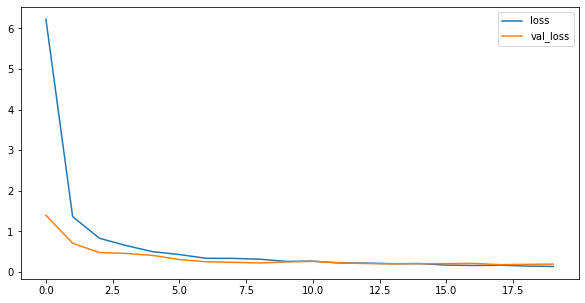

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()

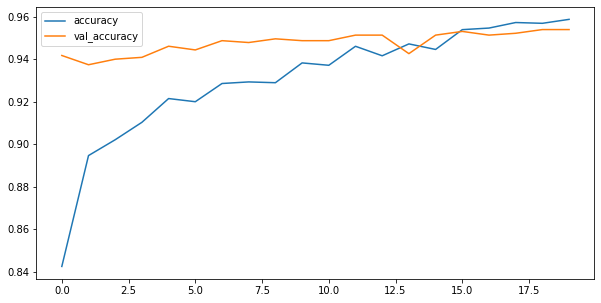

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')